In [8]:
import torch
import os
from pathlib import Path
from logs.locallogger import LocalLogger2D, Logger
from training.trainer import MRTrainer
from datasets.volumesignal import VolumeSignal
from networks.mrnet import MRFactory
from datasets.pyramids import create_MR_structure
from datasets.sampler3d import make3Dcoords
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "train3d.ipynb"
BASE_DIR = Path('.').absolute().parents[0]
VOXEL_PATH = BASE_DIR.joinpath('vox')
MODEL_PATH = BASE_DIR.joinpath('models')

In [3]:
project_name = "perlin3d"
config_file = '../configs/config_3d_m_net.yml'
with open(config_file) as f:
    hyper = yaml.load(f, Loader=SafeLoader)
    print(hyper)

{'model': 'M', 'in_features': 3, 'hidden_layers': 1, 'hidden_features': [120, 80, 100, 160], 'bias': True, 'max_stages': 1, 'period': 2, 'domain': [-1, 1], 'omega_0': [8, 16, 48], 'hidden_omega_0': [30, 30, 30, 30], 'superposition_w0': False, 'sampling_scheme': 'regular', 'decimation': False, 'filter': 'none', 'attributes': ['d0'], 'loss_function': 'mse', 'opt_method': 'Adam', 'lr': 0.0005, 'loss_tol': 1e-14, 'diff_tol': 1e-11, 'max_epochs_per_stage': [10, 500, 500, 500], 'batch_size': 1, 'batch_samples_perc': 1.0, 'image_name': 'wood_noise3d128.npy', 'width': 128, 'height': 128, 'channels': 1, 'device': 'cpu', 'eval_device': 'cpu', 'save_format': 'general', 'visualize_grad': True, 'extrapolate': [-3, 3]}


In [4]:
base_signal = VolumeSignal.init_fromfile(
                    os.path.join(VOXEL_PATH, hyper['image_name']),
                    domain=hyper['domain'],
                    batch_samples_perc=hyper['batch_samples_perc'],
                    sampling_scheme=hyper['sampling_scheme'],
                    attributes=hyper['attributes'],
                    channels=hyper['channels'])
train_dataloader = create_MR_structure(base_signal, hyper['max_stages'],
                                        hyper['filter'], hyper['decimation'])
test_dataloader = create_MR_structure(base_signal, hyper['max_stages'],
                                        hyper['filter'])

In [5]:
# locallogger = LocalLogger2D(project_name,
#                             f"{hyper['model']}{hyper['filter'][0].upper()}{hyper['image_name'][0:4]}_",
#                             hyper,
#                             BASE_DIR, 
#                             to_file=True)
locallogger = Logger()
mrmodel = MRFactory.from_dict(hyper)
print("Model: ", type(mrmodel))
mrtrainer = MRTrainer.init_from_dict(mrmodel, 
                                    train_dataloader, test_dataloader, locallogger, hyper)
mrtrainer.train(hyper['device'])

Model:  <class 'networks.mrnet.MNet'>


In [6]:
filename = f"3D{hyper['model']}{hyper['filter'][0].upper()}{hyper['image_name'][0:4]}.pth"
path = os.path.join(MODEL_PATH, filename)

MRFactory.save(mrmodel, path)

In [9]:
mrmodel_eval = MRFactory.load_state_dict(path)

output = mrmodel_eval(make3Dcoords(hyper['width'], hyper['height'], 128, *hyper['domain']))
model_out = torch.clamp(output['model_out'], 0.0, 1.0)

out_volume = model_out.cpu().view(hyper['width'], hyper['height'], 128).detach().numpy()

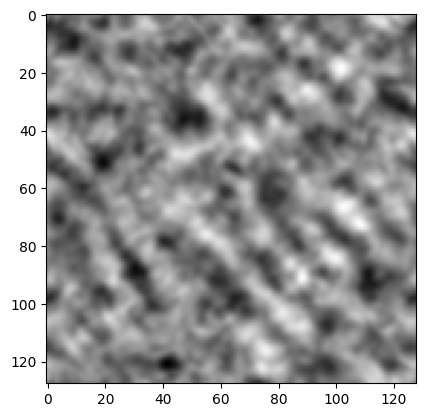

In [16]:
plt.imshow(out_volume[10, :], cmap='gray')